# Initial data and problem exploration



In [51]:
import xarray as xr
import pandas as pd
import urllib.request
import numpy as np
from glob import glob
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import os

In [5]:
import cartopy.feature as cfeature
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

## UK Met Office Global datasets on AWS

Following https://github.com/MetOffice/aws-earth-examples/blob/master/examples/1.%20Getting%20Started.ipynb

In [7]:
import boto3

In [8]:
s3 = boto3.resource('s3')

In [15]:
my_bucket = s3.Bucket('aws-earth-mo-atmospheric-global-prd')

In [16]:
for my_bucket_object in my_bucket.objects.all():
    print(my_bucket_object)

NoCredentialsError: Unable to locate credentials

In [2]:
sample_sns_message = {
    'model': 'mo-atmospheric-mogreps-g-prd',
    'ttl': 1544268873,
    'time': '2018-12-13T09:00:00Z',
    'created_time': '2018-12-06T11:22:27Z',
    'name': 'air_temperature',
    'object_size': 711463962,
    'forecast_period': 615600,
    'forecast_reference_time': '2018-12-06T06:00:00Z',
    'pressure': '100000.0 97500.0 95000.0 92500.0 90000.0 85000.0 80000.0 75000.0 70000.0 65000.0 60000.0 55000.0 50000.0 45000.0 40000.0 37500.0 35000.0 32500.0 30000.0 27500.0 25000.0 22500.0 20000.0 17500.0 15000.0 12500.0 10000.0 7000.0 5000.0 4000.0 3000.0 2000.0 1000.0',
    'forecast_period_units': 'seconds',
    'pressure_units': 'Pa',
    'bucket': 'aws-earth-mo-examples',
    'key': 'cafef7005477edb001aa7dc50eab78c5ef89d420.nc',
    'realization': '0 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34'
}

In [3]:
def download_data_object(sns_message):
    url = "https://s3.eu-west-2.amazonaws.com/" + sns_message['bucket'] + "/" + sns_message['key']
    urllib.request.urlretrieve(url, sns_message['key']) # save in this directory with same name

In [4]:
download_data_object(sample_sns_message)

KeyboardInterrupt: 

https://data.informaticslab.co.uk/mogreps_data_basics.html

In [17]:
def make_data_object_name(dataset_name, year, month, day, hour, realization, forecast_period):
    template_string = "prods_op_{}_{:02d}{:02d}{:02d}_{:02d}_{:02d}_{:03d}.nc"
    return template_string.format(dataset_name, year, month, day, hour, realization, forecast_period)

def download_data_object(dataset_name, data_object_name):
    url = "https://s3.eu-west-2.amazonaws.com/" + dataset_name + "/" + data_object_name
    urllib.request.urlretrieve(url, data_object_name) # save in this directory with same name

In [20]:
obj_name = make_data_object_name('mogreps-uk', 2020, 1, 1, 3, 0, 3)
download_data_object('mogreps-uk', obj_name)

HTTPError: HTTP Error 404: Not Found

In [19]:
!ls

01-Initial_EDA.ipynb
cafef7005477edb001aa7dc50eab78c5ef89d420.nc
prods_op_mogreps-uk_20130101_03_00_003.nc


## TIGGE ECMWF

In [21]:
from ecmwfapi import ECMWFDataServer
server = ECMWFDataServer()
server.retrieve({
    "class": "ti",
    "dataset": "tigge",
    "date": "2020-11-01/to/2020-11-02",
    "expver": "prod",
    "levtype": "sfc",
    "origin": "ecmf",
    "param": "228228",
    "step": "0/6/12/18/24/30/36/42/48/54/60/66/72",
    "time": "00:00:00",
    "type": "cf",
    "target": "output",
})

2020-11-29 07:54:41 ECMWF API python library 1.6.1
2020-11-29 07:54:41 ECMWF API at https://api.ecmwf.int/v1
2020-11-29 07:54:41 Welcome Stephan Rasp
2020-11-29 07:54:43 In case of problems, please check https://confluence.ecmwf.int/display/WEBAPI/Web+API+FAQ or contact servicedesk@ecmwf.int
2020-11-29 07:54:43 Request submitted
2020-11-29 07:54:43 Request id: 5fc345b3a3a6e62bab4d2e4f
2020-11-29 07:54:43 Request is submitted
2020-11-29 07:54:45 Request is active


KeyboardInterrupt: 

## YOPP

In [24]:
ds = xr.open_dataset('../data/yopp.grib', engine='pynio').TP_GDS4_SFC

In [25]:
ds

<xarray.Dataset>
Dimensions:                (forecast_time1: 17, g4_lat_2: 1280, g4_lon_3: 2576, initial_time0_hours: 2)
Coordinates:
  * initial_time0_hours    (initial_time0_hours) datetime64[ns] 2020-11-01 20...
  * g4_lat_2               (g4_lat_2) float32 89.892395 89.753006 ... -89.892395
  * g4_lon_3               (g4_lon_3) float32 0.0 0.13975145 ... 359.86
  * forecast_time1         (forecast_time1) timedelta64[ns] 00:00:00 ... 2 da...
Data variables:
    TP_GDS4_SFC            (initial_time0_hours, forecast_time1, g4_lat_2, g4_lon_3) float32 ...
    initial_time0_encoded  (initial_time0_hours) float64 ...
    initial_time0          (initial_time0_hours) |S0 ...

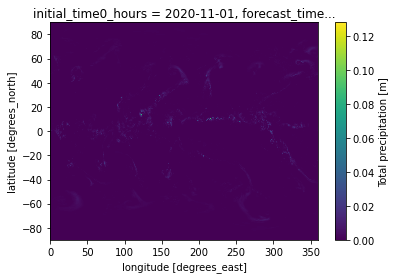

In [28]:
ds.TP_GDS4_SFC[0, 1].plot()

## NRMS data

In [4]:
def time_from_fn(fn):
    s = fn.split('/')[-1].split('_')[-1]
    year = s[:4]
    month = s[4:6]
    day = s[6:8]
    hour = s[9:11]
    return np.datetime64(f'{year}-{month}-{day}T{hour}')

In [5]:
def open_nrms(path):
    fns = sorted(glob(f'{path}/*'))
    dss = [xr.open_dataset(fn, engine='pynio') for fn in fns]
    times = [time_from_fn(fn) for fn in fns]
    times = xr.DataArray(times, name='time', dims=['time'], coords={'time': times})
    ds = xr.concat(dss, times).rename({'lat_0': 'latitude', 'lon_0': 'longitude'})
    da = ds[list(ds)[0]].rename('tp')
    return da

In [50]:
lons = slice(260, 280)
lats = slice(45, 30)

In [43]:
def get_mrms_fn(path, source, year, month, day, hour):
    month, day, hour = [str(x).zfill(2) for x in [month, day, hour]]
    fn = f'{path}/{source}/MRMS_{source}_00.00_{year}{month}{day}-{hour}0000.grib2'
#     print(fn)
    return fn

In [47]:
def load_mrms_data(path, start_time, stop_time, accum=3):
    times = pd.to_datetime(np.arange(start_time, stop_time, np.timedelta64(accum, 'h'), dtype='datetime64[h]'))
    das = []
    for t in times:
        if os.path.exists(get_mrms_fn(path, f'MultiSensor_QPE_0{accum}H_Pass1', t.year, t.month, t.day, t.hour)):
            ds = xr.open_dataset(get_mrms_fn(path, f'MultiSensor_QPE_0{accum}H_Pass1', t.year, t.month, t.day, t.hour), engine='pynio')
        elif os.path.exists(get_mrms_fn(path, f'MultiSensor_QPE_0{accum}H_Pass2', t.year, t.month, t.day, t.hour)):
            ds = xr.open_dataset(get_mrms_fn(path, f'MultiSensor_QPE_0{accum}H_Pass2', t.year, t.month, t.day, t.hour), engine='pynio')
        elif os.path.exists(get_mrms_fn(path, f'RadarOnly_QPE_0{accum}H', t.year, t.month, t.day, t.hour)):
            ds = xr.open_dataset(get_mrms_fn(path, f'RadarOnly_QPE_0{accum}H', t.year, t.month, t.day, t.hour), engine='pynio')
        else:
            raise Exception(f'No data found for {t}')
        ds = ds.rename({'lat_0': 'latitude', 'lon_0': 'longitude'})
        da = ds[list(ds)[0]].rename('tp')
        das.append(da)
    times = xr.DataArray(times, name='time', dims=['time'], coords={'time': times})
    da = xr.concat(das, times)
    return da

In [48]:
mrms = load_mrms_data('../data/', '2020-10-23', '2020-10-25')

In [49]:
mrms

<xarray.DataArray 'tp' (time: 16, latitude: 3500, longitude: 7000)>
array([[[  0.       ,   0.       ,   0.       , ...,   0.       ,
           0.       ,   0.       ],
        [  0.       ,   0.       ,   0.       , ...,   0.       ,
           0.       ,   0.       ],
        [  0.       ,   0.       ,   0.       , ...,   0.       ,
           0.       ,   0.       ],
        ...,
        [  0.       ,   0.       ,   0.       , ...,   0.       ,
           0.       ,   0.       ],
        [  0.       ,   0.       ,   0.       , ...,   0.       ,
           0.       ,   0.       ],
        [  0.       ,   0.       ,   0.       , ...,   0.       ,
           0.       ,   0.       ]],

       [[-99.9      , -99.9      , -99.9      , ..., -99.9      ,
         -99.9      , -99.9      ],
        [-99.9      , -99.9      , -99.9      , ..., -99.9      ,
         -99.9      , -99.9      ],
        [-99.9      , -99.9      , -99.9      , ..., -99.9      ,
         -99.9      , -99.9      ],
...
        [  0.       ,   0.       ,   0.       , ...,   0.       ,
           0.       ,   0.       ],
        [  0.       ,   0.       ,   0.       , ...,   0.       ,
           0.       ,   0.       ],
        [  0.       ,   0.       ,   0.       , ...,   0.       ,
           0.       ,   0.       ]],

       [[  0.       ,   0.       ,   0.       , ...,   0.5      ,
           0.5      ,   0.5      ],
        [  0.       ,   0.       ,   0.       , ...,   0.5      ,
           0.5      ,   0.5      ],
        [  0.       ,   0.       ,   0.       , ...,   0.5      ,
           0.5      ,   0.5      ],
        ...,
        [  0.       ,   0.       ,   0.       , ...,   0.       ,
           0.       ,   0.       ],
        [  0.       ,   0.       ,   0.       , ...,   0.       ,
           0.       ,   0.       ],
        [  0.       ,   0.       ,   0.       , ...,   0.       ,
           0.       ,   0.       ]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2020-10-23 ... 2020-10-24T21:00:00
  * latitude   (latitude) float32 54.995 54.985 54.975 ... 20.015001 20.005001
  * longitude  (longitude) float32 230.005 230.015 230.025 ... 299.985 299.995
Attributes:
    center:                                         US NOAA Office of Oceanic...
    production_status:                              Research products
    long_name:                                      unknown variable name
    units:                                          unknown
    grid_type:                                      Latitude/longitude
    parameter_discipline_and_category:              Multi-Radar/Multi-Sensor ...
    parameter_template_discipline_category_number:  [  0 209   6  31]
    level_type:                                     Specific altitude above m...
    level:                                          [0.]
    forecast_time:                                  [0]
    forecast_time_units:                            minutes
    initial_time:                                   10/23/2020 (00:00)

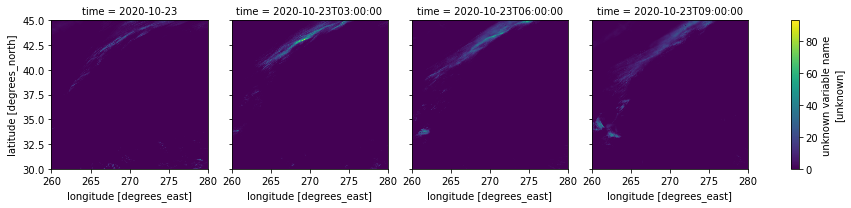

In [54]:
mrms.sel(latitude=lats, longitude=lons)[:4].plot(col='time')

# Old

In [7]:
path = '../data/MultiSensor_QPE_01H_Pass1/'

In [9]:
da1 = open_nrms('../data/MultiSensor_QPE_01H_Pass1/')
da3 = open_nrms('../data/MultiSensor_QPE_03H_Pass1/')

In [52]:
dar = open_nrms('../data/RadarOnly_QPE_03H/')

In [68]:
da3p = open_nrms('../data/MultiSensor_QPE_03H_Pass2/')

In [10]:
da1

<xarray.DataArray 'tp' (time: 39, latitude: 3500, longitude: 7000)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2020-10-23 ... 2020-10-24T23:00:00
  * latitude   (latitude) float32 54.995 54.985 54.975 ... 20.015001 20.005001
  * longitude  (longitude) float32 230.005 230.015 230.025 ... 299.985 299.995
Attributes:
    center:                                         US NOAA Office of Oceanic...
    production_status:                              Research products
    long_name:                                      unknown variable name
    units:                                          unknown
    grid_type:                                      Latitude/longitude
    parameter_discipline_and_category:              Multi-Radar/Multi-Sensor ...
    parameter_template_discipline_category_number:  [  0 209   6  30]
    level_type:                                     Specific altitude above m...
    level:                                          [0.]
    forecast_time:                                  [0]
    forecast_time_units:                            minutes
    initial_time:                                   10/23/2020 (00:00)

In [12]:
da3

<xarray.DataArray 'tp' (time: 39, latitude: 3500, longitude: 7000)>
array([[[0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        ...,
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ]],

       [[0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        ...,
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ]],

       [[0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        ...,
...
        ...,
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ]],

       [[0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        ...,
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ]],

       [[0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        ...,
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2020-10-23 ... 2020-10-24T23:00:00
  * latitude   (latitude) float32 54.995 54.985 54.975 ... 20.015001 20.005001
  * longitude  (longitude) float32 230.005 230.015 230.025 ... 299.985 299.995
Attributes:
    center:                                         US NOAA Office of Oceanic...
    production_status:                              Research products
    long_name:                                      unknown variable name
    units:                                          unknown
    grid_type:                                      Latitude/longitude
    parameter_discipline_and_category:              Multi-Radar/Multi-Sensor ...
    parameter_template_discipline_category_number:  [  0 209   6  31]
    level_type:                                     Specific altitude above m...
    level:                                          [0.]
    forecast_time:                                  [0]
    forecast_time_units:                            minutes
    initial_time:                                   10/23/2020 (00:00)

In [13]:
da13 = da1.rolling(time=3).sum()

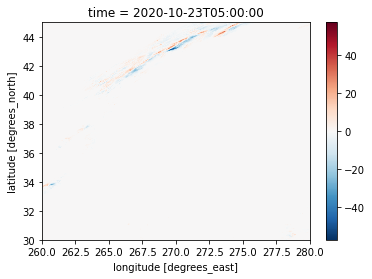

In [15]:
(da13 - da3).isel(time=3).sel(latitude=lats, longitude=lons).plot()

Text(0.5, 1.05, '1h accumulation with rolling(time=3).sum()')

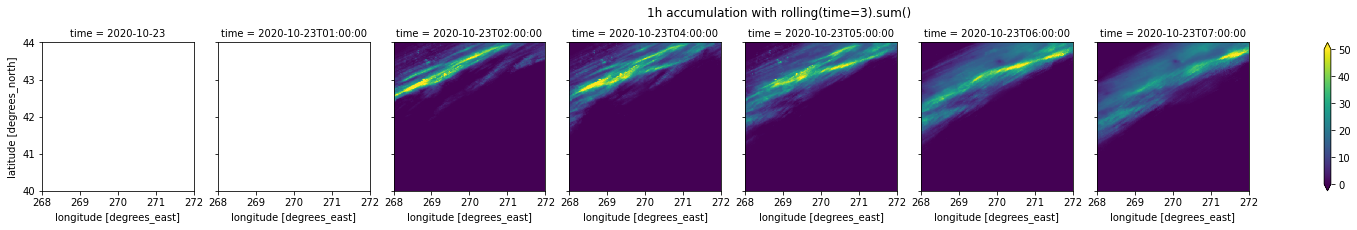

In [50]:
da13.isel(time=slice(0, 7)).sel(latitude=slice(44, 40), longitude=slice(268, 272)).plot(col='time', vmin=0, vmax=50)
plt.suptitle('1h accumulation with rolling(time=3).sum()', y=1.05)

Text(0.5, 1.05, '3h accumulation')

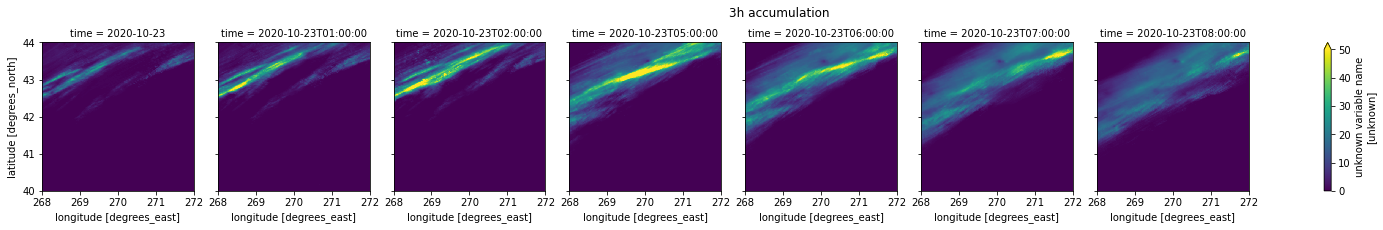

In [51]:
da3.isel(time=slice(0, 7)).sel(latitude=slice(44, 40), longitude=slice(268, 272)).plot(col='time', vmin=0, vmax=50)
plt.suptitle('3h accumulation', y=1.05)

Text(0.5, 1.05, '3h accumulation radar')

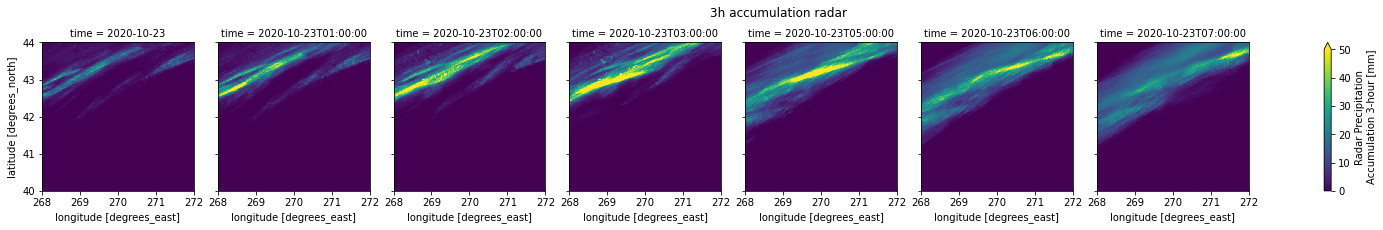

In [53]:
dar.isel(time=slice(0, 7)).sel(latitude=slice(44, 40), longitude=slice(268, 272)).plot(col='time', vmin=0, vmax=50)
plt.suptitle('3h accumulation radar', y=1.05)

Text(0.5, 1.05, '3h accumulation')

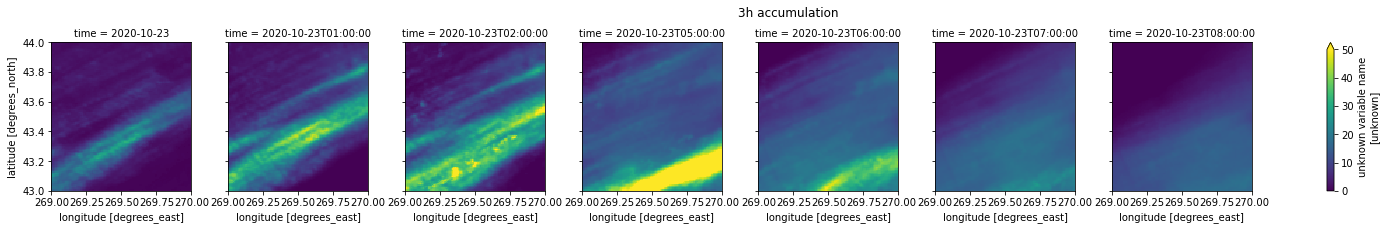

In [54]:
da3.isel(time=slice(0, 7)).sel(latitude=slice(44, 43), longitude=slice(269, 270)).plot(col='time', vmin=0, vmax=50)
plt.suptitle('3h accumulation', y=1.05)

Text(0.5, 1.05, '3h accumulation radar')

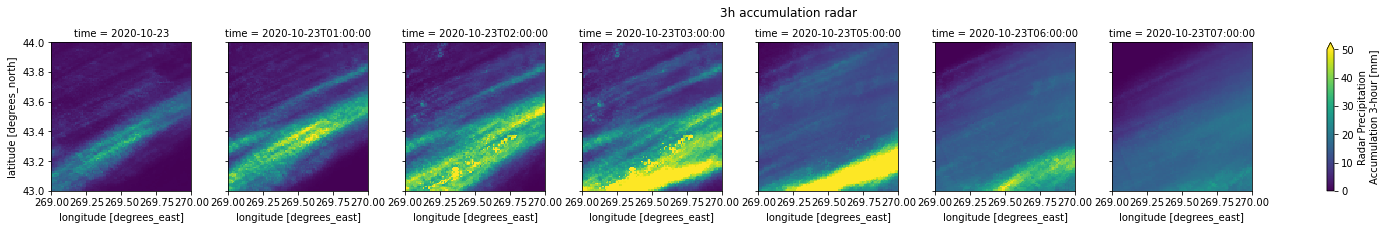

In [55]:
dar.isel(time=slice(0, 7)).sel(latitude=slice(44, 43), longitude=slice(269, 270)).plot(col='time', vmin=0, vmax=50)
plt.suptitle('3h accumulation radar', y=1.05)

In [69]:
for t in np.arange('2020-10-23', '2020-10-25', np.timedelta64(3, 'h'), dtype='datetime64[h]'):
    print(t)
    print('Radar', (dar.time.values == t).sum() > 0)
    print('Pass1', (da3.time.values == t).sum() > 0)
    print('Pass2', (da3p.time.values == t).sum() > 0)

2020-10-23T00
Radar True
Pass1 True
Pass2 True
2020-10-23T03
Radar True
Pass1 False
Pass2 False
2020-10-23T06
Radar True
Pass1 True
Pass2 True
2020-10-23T09
Radar True
Pass1 False
Pass2 True
2020-10-23T12
Radar True
Pass1 True
Pass2 False
2020-10-23T15
Radar True
Pass1 False
Pass2 True
2020-10-23T18
Radar True
Pass1 True
Pass2 True
2020-10-23T21
Radar True
Pass1 False
Pass2 True
2020-10-24T00
Radar True
Pass1 True
Pass2 True
2020-10-24T03
Radar True
Pass1 False
Pass2 False
2020-10-24T06
Radar True
Pass1 True
Pass2 True
2020-10-24T09
Radar True
Pass1 False
Pass2 True
2020-10-24T12
Radar True
Pass1 True
Pass2 False
2020-10-24T15
Radar True
Pass1 True
Pass2 False
2020-10-24T18
Radar True
Pass1 True
Pass2 False
2020-10-24T21
Radar True
Pass1 True
Pass2 False


In [61]:
t

numpy.datetime64('2020-10-24T23','h')

In [64]:
(dar.time.values == t).sum() > 0

True

In [59]:
da3.time.values

array(['2020-10-23T00:00:00.000000000', '2020-10-23T01:00:00.000000000',
       '2020-10-23T02:00:00.000000000', '2020-10-23T05:00:00.000000000',
       '2020-10-23T06:00:00.000000000', '2020-10-23T07:00:00.000000000',
       '2020-10-23T08:00:00.000000000', '2020-10-23T10:00:00.000000000',
       '2020-10-23T11:00:00.000000000', '2020-10-23T12:00:00.000000000',
       '2020-10-23T13:00:00.000000000', '2020-10-23T14:00:00.000000000',
       '2020-10-23T16:00:00.000000000', '2020-10-23T17:00:00.000000000',
       '2020-10-23T18:00:00.000000000', '2020-10-23T19:00:00.000000000',
       '2020-10-23T20:00:00.000000000', '2020-10-23T22:00:00.000000000',
       '2020-10-23T23:00:00.000000000', '2020-10-24T00:00:00.000000000',
       '2020-10-24T01:00:00.000000000', '2020-10-24T02:00:00.000000000',
       '2020-10-24T05:00:00.000000000', '2020-10-24T06:00:00.000000000',
       '2020-10-24T07:00:00.000000000', '2020-10-24T08:00:00.000000000',
       '2020-10-24T11:00:00.000000000', '2020-10-24

In [40]:
def plot_facet(da, title='', **kwargs):
    p = da.plot(
        col='time', col_wrap=3,
        subplot_kws={'projection': ccrs.PlateCarree()},
        transform=ccrs.PlateCarree(),
        figsize=(15, 15), **kwargs
    )
    for ax in p.axes.flat:
        ax.coastlines()
        ax.add_feature(states_provinces, edgecolor='gray')
#         ax.set_extent([113, 154, -11, -44], crs=ccrs.PlateCarree())
    plt.suptitle(title);

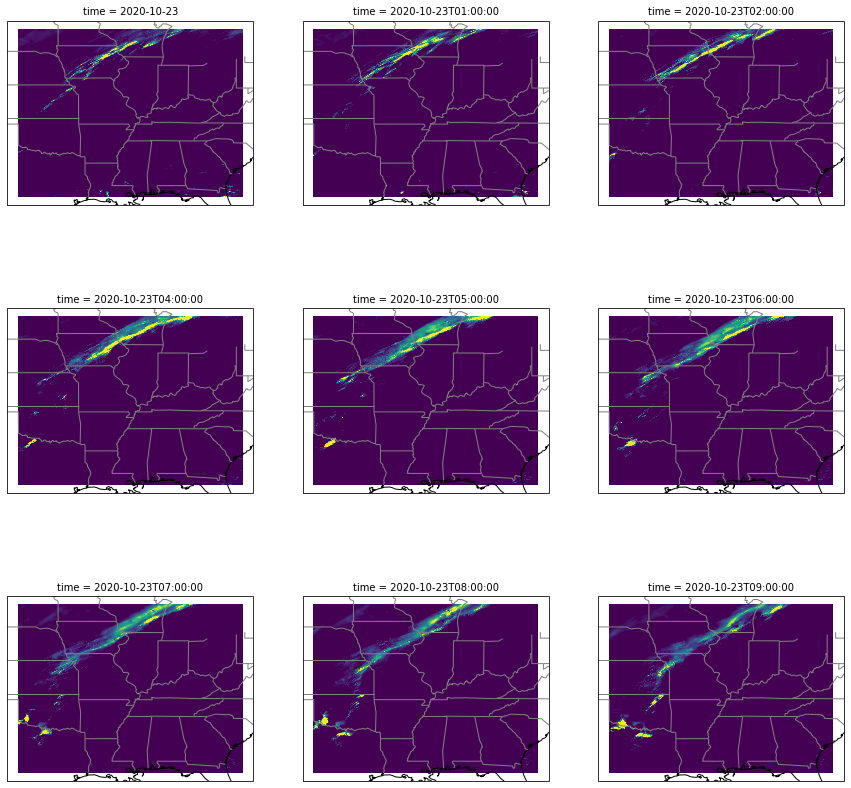

In [41]:
plot_facet(da.isel(time=slice(0, 9)).sel(latitude=lats, longitude=lons), vmin=0, vmax=10, add_colorbar=False)

In [60]:
import holoviews as hv
hv.extension('matplotlib')
from holoviews import opts
opts.defaults(opts.Scatter3D(color='Value', cmap='fire', edgecolor='black', s=50))

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

In [61]:
hv_ds = hv.Dataset(da.sel(latitude=lats, longitude=lons))

In [62]:
hv_ds

:Dataset   [time,latitude,longitude]   (tp)

In [63]:
a = hv_ds.to(hv.Image, kdims=["longitude", "latitude"], dynamic=False)

In [ ]:
a.opts(colorbar=True, fig_size=200, cmap='viridis')

In [53]:
da.longitude.diff('longitude').min()

<xarray.DataArray 'longitude' ()>
array(0.00997925)

In [30]:
!cp ../data/yopp/2020-10-23.nc ../data/yopp/2020-10-23.grib

In [32]:
a = xr.open_dataset('../data/yopp/2020-10-23.grib', engine='pynio')

In [35]:
a

<xarray.Dataset>
Dimensions:                (forecast_time1: 25, g4_lat_2: 1280, g4_lon_3: 2576, initial_time0_hours: 2)
Coordinates:
  * initial_time0_hours    (initial_time0_hours) datetime64[ns] 2020-10-23 20...
  * g4_lat_2               (g4_lat_2) float32 89.892395 89.753006 ... -89.892395
  * g4_lon_3               (g4_lon_3) float32 0.0 0.13975145 ... 359.86
  * forecast_time1         (forecast_time1) timedelta64[ns] 00:00:00 ... 3 da...
Data variables:
    TP_GDS4_SFC            (initial_time0_hours, forecast_time1, g4_lat_2, g4_lon_3) float32 ...
    initial_time0_encoded  (initial_time0_hours) float64 2.02e+09 2.02e+09
    initial_time0          (initial_time0_hours) |S18 b'10/23/2020 (00:00)' b...

In [36]:
a.g4_lat_2.diff('g4_lat_2')

<xarray.DataArray 'g4_lat_2' (g4_lat_2: 1279)>
array([-0.13938904, -0.14021301, -0.14040375, ..., -0.14040375,
       -0.14021301, -0.13938904], dtype=float32)
Coordinates:
  * g4_lat_2  (g4_lat_2) float32 89.753006 89.61279 ... -89.753006 -89.892395

In [37]:
a.g4_lon_3.diff('g4_lon_3')

<xarray.DataArray 'g4_lon_3' (g4_lon_3: 2575)>
array([0.13975145, 0.13975145, 0.13975146, ..., 0.13977051, 0.13973999,
       0.13973999], dtype=float32)
Coordinates:
  * g4_lon_3  (g4_lon_3) float32 0.13975145 0.2795029 ... 359.72025 359.86

In [39]:
!cp ../data/tigge/2020-10-23.nc ../data/tigge/2020-10-23.grib

In [41]:
b = xr.open_dataset('../data/tigge/2020-10-23.grib', engine='pynio')

In [42]:
b

<xarray.Dataset>
Dimensions:                (forecast_time0: 13, initial_time0_hours: 4, lat_0: 1280, lon_0: 2576)
Coordinates:
  * initial_time0_hours    (initial_time0_hours) datetime64[ns] 2020-10-23 .....
  * lat_0                  (lat_0) float32 89.892395 89.753006 ... -89.892395
  * lon_0                  (lon_0) float32 0.0 0.13975155 ... 359.7205 359.86026
  * forecast_time0         (forecast_time0) timedelta64[ns] 0 days 00:00:00 ....
Data variables:
    tp_P11_L1_GGA0_acc     (initial_time0_hours, forecast_time0, lat_0, lon_0) float32 ...
    initial_time0_encoded  (initial_time0_hours) float64 ...
    initial_time0          (initial_time0_hours) |S0 ...